# Proyecto ML. Show/ No Show

In [0]:
#Import your libraries
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (16,6)

#Fechas
import datetime

#Interact
from ipywidgets import interact

#Umbalanced
from imblearn.under_sampling import NearMiss

#Statsmodels
import statsmodels.api as sm

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import LinearSVC, SVC

from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.decomposition import PCA


## Importar y describir el dataset

In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
citas = drive.CreateFile({'id':'14wzIczS1L5EII31U1f0298OiJyeGw4UC'}) # replace the id with id of file you want to access
citas.GetContentFile('show_no_show.csv') 

In [0]:
citas = pd.read_csv('show_no_show.csv') 

In [0]:
citas.columns = map(str.lower, citas.columns)

In [0]:
def heatmap_ml (df):
    corr = df.corr().round(2)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(16, 8))

        ax = sns.heatmap(corr, cmap = 'RdBu_r', annot=True,  mask=mask, vmax=1, vmin= -1, square=True)

In [0]:
def describe_df(df):
    
    """
    Muestra información básica del dataframe que le pases.
    
    Input:
    -DataFrame
    
    Output:
    - Número de filas y columnas
    - DataFrame con:
        * 'type': Tipos de columnas
        * 'nan': Número de valores nulos
        * 'nan_ratio_col': Ratio de valores nulos en la columna
        * 'nan_ratio_total': Ratio de valores nulos en el total del dataset
        * 'unique_values': Número de valores únicos que tiene esa columna
        * 'mean': media de las columnas numéricas
        * 'std': desviación estándard de las columnas numéricas
        * 'min': mínimo de las columnas numéricas
        * '25%': primer cuartil de las columnas numéricas
        * '50%': segundo cuartil de las columnas numéricas
        * '75%': tercer cuartil de las columnas numéricas
        * 'max': máximo de las columnas numéricas
        
    - Heatmap de correlación
    """
    
    print(f'Hay un total de {df.shape[0]} filas y {df.shape[1]} columnas.')
    
    print (heatmap_ml(df))
    
    describe_df = pd.DataFrame(df.dtypes, columns = ["type"])
    describe_df["nan"] = df.isna().sum()
    describe_df["nan_ratio_col"] = [round(df.isna().sum()[col]/len(df[col])*100, 2) for col in df.columns]
    describe_df["nan_ratio_total"] = [round(df.isna().sum()[col]/df.shape[0]*100, 2) for col in df.columns]
    describe_df['unique_values'] = [len(pd.unique(df[col])) for col in df.columns]
    describe_df = describe_df.join(df.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']], on = describe_df.index)
    
    return describe_df

Hay un total de 110527 filas y 15 columnas.
None


,type,nan,nan_ratio_col,nan_ratio_total,unique_values,mean,std,min,25%,50%,75%,max
unnamed: 0,int64,0,0.00,0.00,110527,5.526300e+04,3.190654e+04,0.000000e+00,2.763150e+04,5.526300e+04,8.289450e+04,1.105260e+05
patientid,float64,0,0.00,0.00,62299,1.474963e+14,2.560949e+14,3.921784e+04,4.172614e+12,3.173184e+13,9.439172e+13,9.999816e+14
appointmentid,int64,0,0.00,0.00,110527,5.675305e+06,7.129575e+04,5.030230e+06,5.640286e+06,5.680573e+06,5.725524e+06,5.790484e+06
gender,object,345,0.31,0.31,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scheduledday,object,0,0.00,0.00,103549,NaN,NaN,NaN,NaN,NaN,NaN,NaN
appointmentday,object,0,0.00,0.00,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,int64,0,0.00,0.00,221,3.704903e+01,2.352466e+01,-2.320000e+02,1.800000e+01,3.700000e+01,5.500000e+01,3.100000e+02
neighbourhood,object,0,0.00,0.00,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scholarship,int64,0,0.00,0.00,2,9.826558e-02,2.976748e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
hipertension,int64,0,0.00,0.00,2,1.972459e-01,3.979213e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


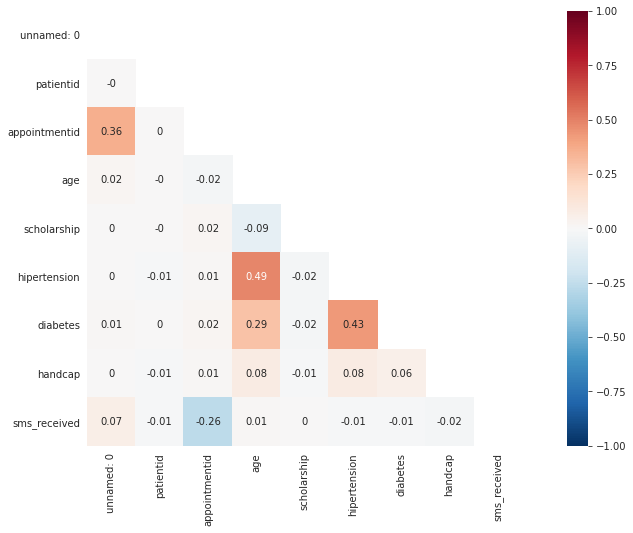

In [78]:
describe_df (citas)

El único atributo con nulos es <code>gender</code>. Pasaremos a analizar más en profundidad el resto de características para extraer más información.

## Data cleaning

### Estrategia

In [0]:
def date_group(hour):
    if 6 <= hour > 11:
        return 1
    elif 11 <= hour > 15:
        return 2
    elif 15 <= hour > 22:
        return 3
    else:
        return 0

In [0]:
def cat_column_analysis (df, col):
    
    """
    Dada un columna devuelve información relacionada con nulos y distribución.
    
    Inputs:
    df. datafrme
    col. nombre de la columna
    
    Output:
    -Valores nulos y su ratio si hay.
    -% de cada valor
    -bar plot
    
    """
    
    df_temp = pd.DataFrame(df[col])
    
    #Valores nulos
    if df[col].isnull().sum()>0:  
        print(f"Valores nulos: {df[col].isnull().sum()}. Un {round((df[col].isnull().sum()/len(df[col])*100),2)}%")
        df_temp[col] = df[col].fillna("NaN")
    else:
        print("No hay valores nulos.")
        
    # % según los valores únicos    
    print("Ratio de valores:")
    cd = pd.DataFrame(df_temp[col].value_counts())
    cd["%"] = [round((cd[col][value]/cd[col].sum()),4)*100 for value in cd.index]
    print(cd)
    
    #Visualización de la distribución
    print("Distribución:")
    display(df_temp[col].hist())
    plt.show()
    
    print('\n')
    
    #mostrar el impacto de las distintos valores de la variable en el target (No-show)
    df_temp2 = pd.DataFrame(citas[[col,'no-show']])

    print(f"Impacto de {col} en No-shows:")

    df_temp2 = df_temp2.groupby([col,'no-show']).agg({col:'count'})
    df_temp2['%'] = [round((df_temp2[col][value]/df_temp2[col][df_temp2.index.get_level_values(0)==value[0]].sum())*100,2)
    for value in df_temp2.index]
    print(df_temp2)

In [0]:
def cat_ord_to_num (df, col, lst):

    """
    Convierte una categórica ordinal en numérica manteniendo el orden.

    Input:
    * df : dataframe
    * col: columna a convertir
    * lst : lista ordenada de valores únicos de la columna a convertir

    Output:
    *new_col :lista con los valores convertidos

    """

    new_col = df[col].apply(lambda x: lst.index(x))

    return new_col

### PatientId

Convertimos a integer la columna <code>patientid</code> para poder manipularla más facilmente y no tener números en notación científica.

In [0]:
appointments_per_patient_id = citas.groupby(['patientid']).agg({'appointmentid':'count'})

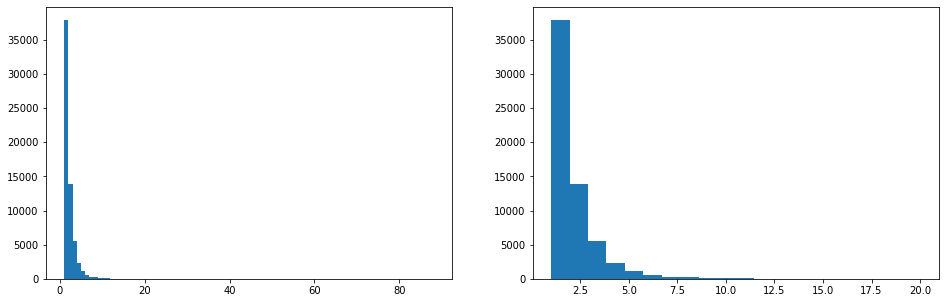

In [83]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16,5)

x1 = appointments_per_patient_id['appointmentid']
x2 = appointments_per_patient_id['appointmentid'][appointments_per_patient_id['appointmentid']<=20]


axs[0].hist(x1, bins=88)
axs[1].hist(x2, bins=20)

plt.show()


### ScheduledDay y Appointmentday

La estructura actual de los atributos relacionados con fechas no nos permiten trabajar con ellos. Pasaremos a extraer la información que necesitamos usando ReGex y convirtiendo los datos a formato <code>datetime</code>.

In [84]:
# Checking how different are the values in both columns

print('ScheduledDay column:', '\n\n', citas['scheduledday'],'\n\n')
print('AppointmentDay column:', '\n\n', citas['appointmentday'])

ScheduledDay column: 

 0         2016-04-29T18:38:08Z
1         2016-04-29T16:08:27Z
2         2016-04-29T16:19:04Z
3         2016-04-29T17:29:31Z
4         2016-04-29T16:07:23Z
                  ...         
110522    2016-05-03T09:15:35Z
110523    2016-05-03T07:27:33Z
110524    2016-04-27T16:03:52Z
110525    2016-04-27T15:09:23Z
110526    2016-04-27T13:30:56Z
Name: scheduledday, Length: 110527, dtype: object 


AppointmentDay column: 

 0         2016-04-29T00:00:00Z
1         2016-04-29T00:00:00Z
2         2016-04-29T00:00:00Z
3         2016-04-29T00:00:00Z
4         2016-04-29T00:00:00Z
                  ...         
110522    2016-06-07T00:00:00Z
110523    2016-06-07T00:00:00Z
110524    2016-06-07T00:00:00Z
110525    2016-06-07T00:00:00Z
110526    2016-06-07T00:00:00Z
Name: appointmentday, Length: 110527, dtype: object


In [0]:
citas['scheduledday'] = pd.to_datetime(citas['scheduledday'].str.replace('T',' ').str.replace('Z',''))
citas['appointmentday'] = pd.to_datetime(citas['appointmentday'].str.replace('T',' ').str.replace('Z',''))

In [0]:
citas['scheduleddate'] = pd.to_datetime(citas['scheduledday'].dt.date)
citas['scheduledweekday'] = citas['scheduledday'].dt.weekday #Monday 0 Sunday 6
citas['scheduledhour'] = citas['scheduledday'].dt.hour
citas['appointmentdate'] = pd.to_datetime(citas['appointmentday'].dt.date)
citas['appointmentweekday'] = citas['appointmentday'].dt.weekday #Monday 0 Sunday 6
citas['appointmenthour'] = citas['appointmentday'].dt.hour

Creating a flag to tell wether the Appointment is in the same day as it was scheduled or not

In [0]:
citas['samedayflag'] = citas['scheduledweekday'] == citas['appointmentweekday']

Con el siguiente gráfico podemos ver la distribución de las visitas a lo largo del día. 

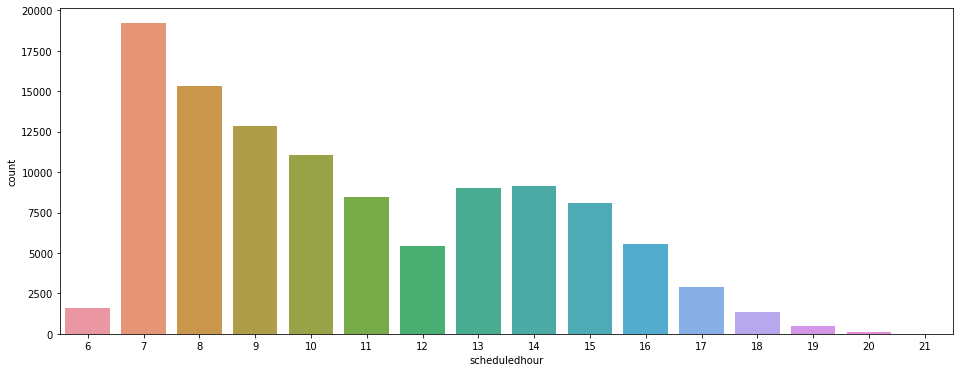

In [88]:
sns.countplot(x=citas['scheduledhour'])

- Hay un mayor número de citas por la mañana y algunas horas valle
- El **mayor número de citas** fue entre las **7 y las 10 de la mañana**

También podemos ver la distribución por día de la semana.

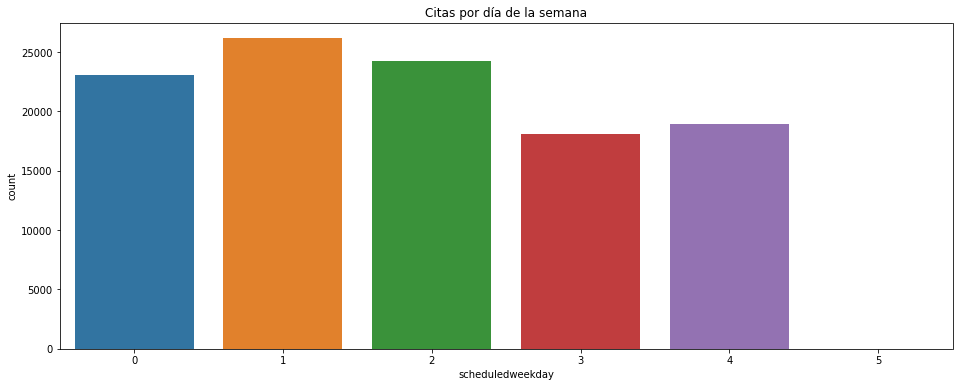

In [89]:
ax = sns.countplot(x=citas['scheduledweekday'])
ax.set_title("Citas por día de la semana")
plt.show()

- El lunes se indica con 0 y el domingo que se indica con 6
- Los **martes y miércoles** son los días para los que se programan la **mayoría de las citas**

In [0]:
citas['days_to_appointment'] = (citas['appointmentday'].dt.date - citas['scheduledday'].dt.date).dt.days

In [0]:
citas.drop(citas[citas['days_to_appointment']<0].index, inplace = True)

Hay 5 citas con agendadas después de la fecha de visita, lo que da valores negativos. Nos tomaremos esto como un error y procedemos a eliminar esa fila.

No hay valores nulos.
Ratio de valores:
     days_to_appointment      %
0                  38563  34.89
2                   6725   6.08
4                   5290   4.79
1                   5213   4.72
7                   4906   4.44
..                   ...    ...
101                    1   0.00
132                    1   0.00
151                    1   0.00
146                    1   0.00
127                    1   0.00

[129 rows x 2 columns]
Distribución:


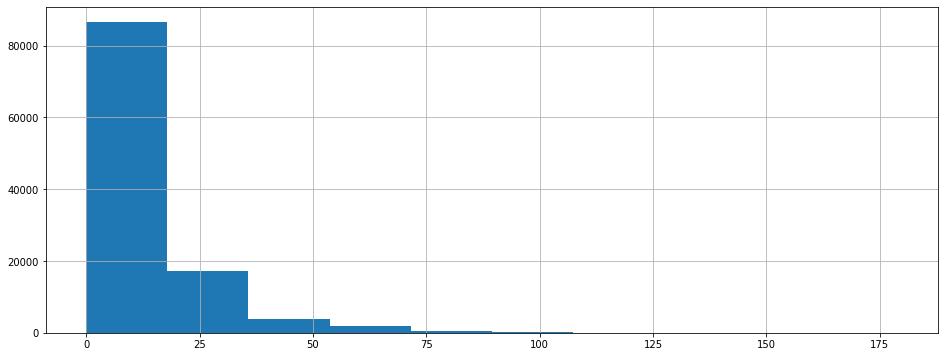



Impacto de days_to_appointment en No-shows:
                             days_to_appointment      %
days_to_appointment no-show                            
0                   No                     36771  95.35
                    Yes                     1792   4.65
1                   No                      4100  78.65
                    Yes                     1113  21.35
2                   No                      5123  76.18
...                                          ...    ...
169                 Yes                        1  12.50
176                 No                        10  62.50
                    Yes                        6  37.50
179                 No                         8  80.00
                    Yes                        2  20.00

[235 rows x 2 columns]


In [92]:
cat_column_analysis (citas, "days_to_appointment")

- La **mayoría de las citas** están programadas para el **mismo día (34,90%)** y sólo el **4,70%** de los pacientes faltan
- La No-show rate aumenta **cuantos más días haya entre la llamada y la cita**: 1 día (21,40%), 2 días (23,51%)  

#### Agrupaciones para simplificar horas

In [0]:
citas['schedulehourgroup'] = citas['scheduledhour'].apply(date_group)

### Age

Hacemos una primera exploración para ver la distribución de las edades visualizando los datos que encontramos en la columna

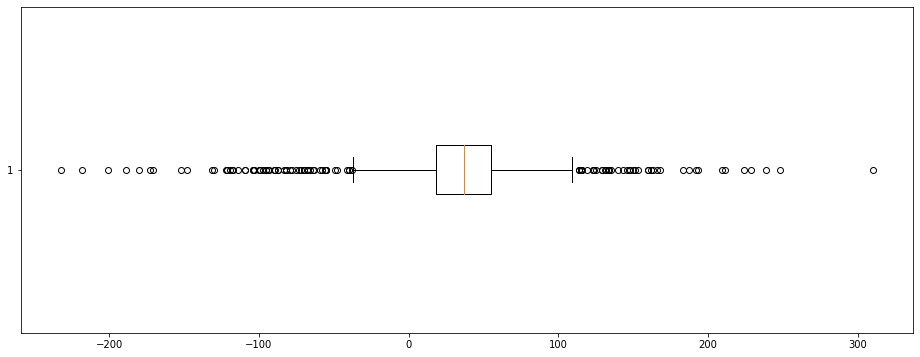

In [94]:
# cambiar escala / horizontal

_=plt.boxplot(citas['age'], vert=False)

In [95]:
#Cuantos appointmentids tiene cada paciente con la misma edad

ages = citas.groupby(['patientid','age']).agg({'appointmentid':'count'}).reset_index().sort_values('patientid')
ages.head()

,patientid,age,appointmentid
0,39217.84439,44,1
1,43741.75652,39,1
2,93779.52927,33,1
3,141724.16655,12,1
4,537615.28476,14,1


In [0]:
#Pacientes que tienen appointments ids con distintas edades
ages_dup = ages[ages.duplicated('patientid',keep=False)].sort_values('patientid')

patient_dup = pd.DataFrame(ages_dup['patientid'].unique())
#si hay mas de un appointment id poner esa edad en el resto
#si ha mas de dos edades mirar las que la diferencia es mayor que uno

In [97]:
ages_dup.head()

,patientid,age,appointmentid
7,2.263866e+07,22,1
8,2.263866e+07,23,1
103,1.217364e+09,48,1
104,1.217364e+09,49,3
108,1.269422e+09,51,1


In [0]:
def age_review(maxv,minv,mean):
    if minv < 0:
        return maxv
    elif maxv > 100:
        return minv
    else:
        return mean

In [99]:
#more than 1 appointment with same age (este ya deberia ser definitvo)
more_than_1_app = ages_dup[ages_dup['appointmentid']>1]

more_than_1_app = more_than_1_app.rename(columns=({'age':'new_age'}))

more_than_1_app.head()

,patientid,new_age,appointmentid
104,1.217364e+09,49,3
133,1.611159e+09,7,2
191,2.522419e+09,55,2
190,2.522419e+09,54,2
263,3.939378e+09,0,3


In [0]:
#sea 1 y no este en la lista anterior
y = ages_dup[~ages_dup['patientid'].isin(more_than_1_app['patientid'])]

y = y.groupby(['patientid'])['age'].agg(['max','min','mean']).reset_index()

y['diff']=y['max']-y['min']

y['new_age'] = y[y['diff']>1].apply(lambda x: age_review(x['max'],x['min'],x['mean']),axis=1)


In [0]:
new_age = more_than_1_app[['patientid','new_age']].append(y[['patientid','new_age']])

In [0]:
citas = citas.merge(new_age[['patientid','new_age']],
                               left_on = ['patientid'],right_on = ['patientid'],how='left')


Para los que no hemos conseguido corregir la edad usar la columna age y siempre en valor absoluto

In [0]:
citas['new_age'] = citas.apply(lambda x: abs(x['age']) if pd.isnull(x['new_age']) else x['new_age'],axis=1)

#### Quitar los outliners

In [0]:
Q1 = citas['new_age'].quantile(0.25) 

Q3 = citas['new_age'].quantile(0.75) 

IQR = citas['new_age'].quantile(0.75) - citas['new_age'].quantile(0.25)

#Outliers

In [0]:
#remove_outliers

citas = citas[(citas['new_age'] < Q3+IQR*1.5) & (citas['new_age'] > Q1-IQR*1.5)]

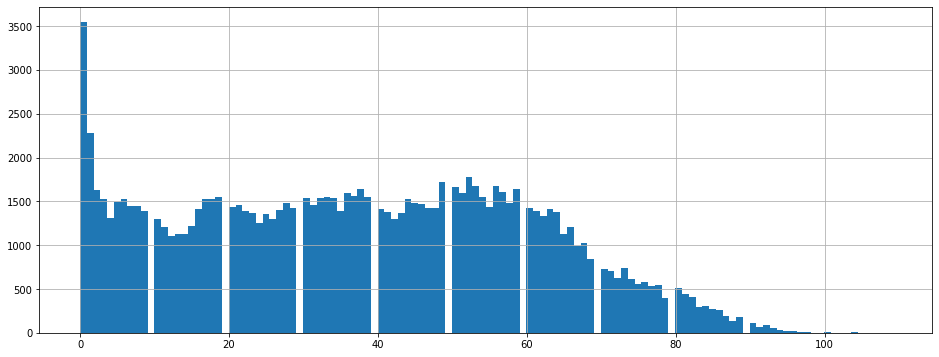

In [106]:
citas['new_age'].hist(bins=120)

### Gender

Valores nulos: 350. Un 0.31%
Ratio de valores:
     gender      %
F     72493  64.68
M     39235  35.01
NaN     350   0.31
Distribución:


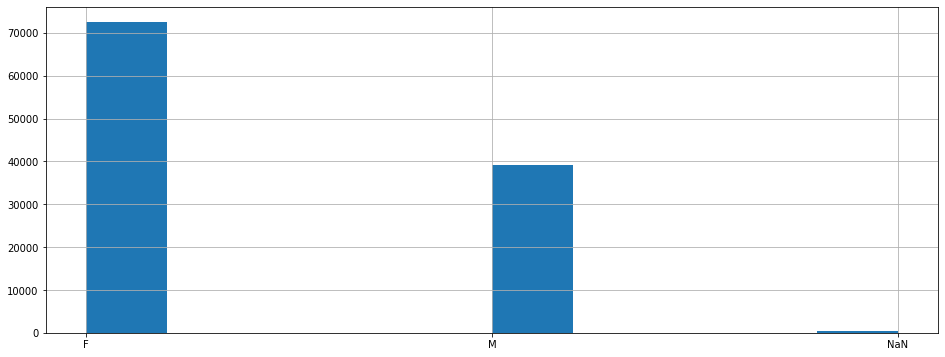



Impacto de gender en No-shows:
                gender      %
gender no-show               
F      No        57759  79.68
       Yes       14734  20.32
M      No        31462  80.19
       Yes        7773  19.81


In [107]:
cat_column_analysis (citas, "gender")



- La mayoría de los pacientes **son mujeres** (64.09%) y tienden a **ir a las citas**. Mientras que los hombres son un 35% más que los hombres y más de un 80% acuden a la cita.

La proporción de valores nulos es pequeña. Al tratarse de una categoria binaria podríamos remplazarlos en proporción a los otros dos valores o crear una nueva categoría de NAs para ver si la gente que no facilita los datos también es la que acabar por no acudir a las citas.

Convertimos los NaN en una string que sea Not Available/NA

In [0]:
citas['gender']=citas['gender'].fillna("N/A")

No hay valores nulos.
Ratio de valores:
     gender      %
F     72493  64.68
M     39235  35.01
N/A     350   0.31
Distribución:


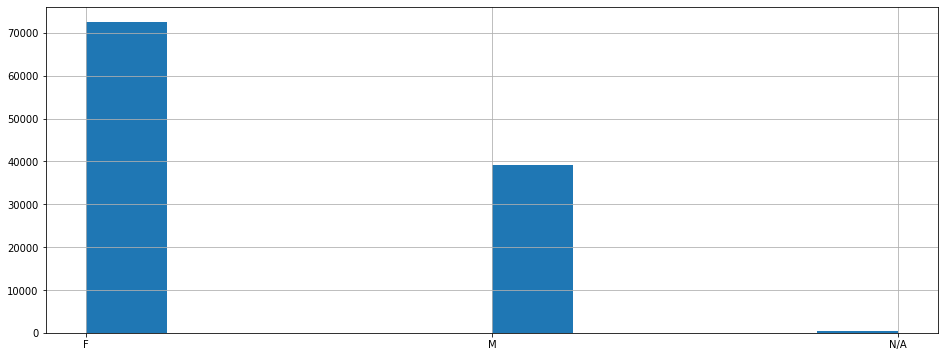



Impacto de gender en No-shows:
                gender      %
gender no-show               
F      No        57759  79.68
       Yes       14734  20.32
M      No        31462  80.19
       Yes        7773  19.81
N/A    No          260  74.29
       Yes          90  25.71


In [109]:
cat_column_analysis (citas, "gender")

### Alcoholism

No hay valores nulos.
Ratio de valores:
          alcoholism      %
None          108516  96.82
Low             1197   1.07
High            1193   1.06
Moderate        1172   1.05
Distribución:


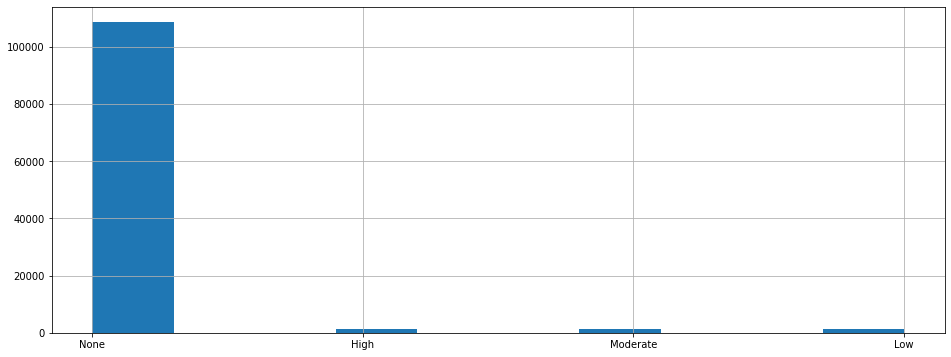



Impacto de alcoholism en No-shows:
                    alcoholism      %
alcoholism no-show                   
High       No              956  80.13
           Yes             237  19.87
Low        No              963  80.45
           Yes             234  19.55
Moderate   No              956  81.57
           Yes             216  18.43
None       No            86606  79.81
           Yes           21910  20.19


In [110]:
cat_column_analysis (citas, "alcoholism")

A pesar de lo que en un principio pensamos que podría ser un atributo categórico binario, haciendo una exploración vemos que es categórico ordinal. Podríamos transformarla a numérico. Para ello crearemos una lista con los valores ordenados:
* 0 = None
* 1 = Low
* 2 = Moderate
* 3 = High

In [0]:
order = ["None", "Low", "Moderate", "High"]
citas['alcoholism'] = pd.to_numeric(cat_ord_to_num(citas, 'alcoholism', order))

In [112]:
citas['alcoholism'].value_counts()

0    108516
1      1197
3      1193
2      1172
Name: alcoholism, dtype: int64

### Scolarship

No hay valores nulos.
Ratio de valores:
   scholarship     %
0       101089  90.2
1        10989   9.8
Distribución:


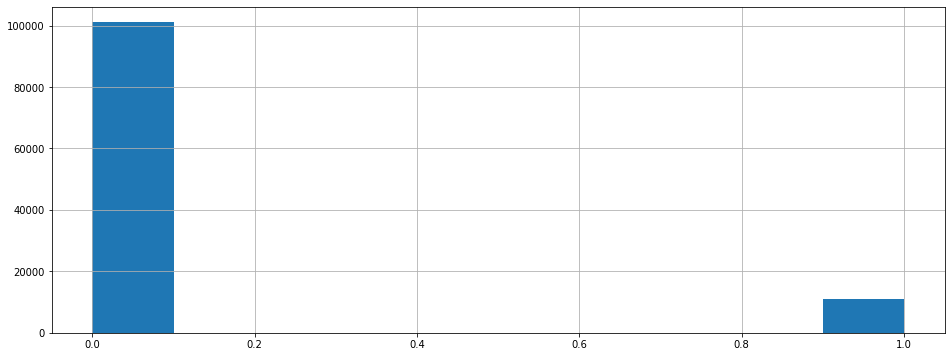



Impacto de scholarship en No-shows:
                     scholarship      %
scholarship no-show                    
0           No             81111  80.24
            Yes            19978  19.76
1           No              8370  76.17
            Yes             2619  23.83


In [113]:
cat_column_analysis (citas,'scholarship')

- Los pacientes que reciben una beca (apoyo social) tienen **No-show rates más altas** (24,33%) que los que no reciben ningún tipo de apoyo (19,56%)

### Hipertension

No hay valores nulos.
Ratio de valores:
   hipertension      %
0         89869  80.18
1         22209  19.82
Distribución:


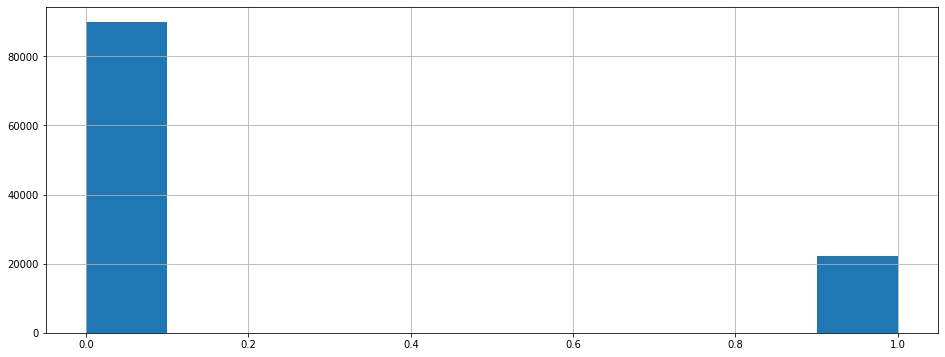



Impacto de hipertension en No-shows:
                      hipertension      %
hipertension no-show                     
0            No              71103  79.12
             Yes             18766  20.88
1            No              18378  82.75
             Yes              3831  17.25


In [114]:
cat_column_analysis (citas,'hipertension')

- La gente con hipertension representa un 20% de la muestra con lo que la podemos considerar significativa
- Podemos observar que la gente con hipertensión hace **menos No-shows que la gente sin**

### Diabetes

No hay valores nulos.
Ratio de valores:
   diabetes      %
0    104002  92.79
1      8076   7.21
Distribución:


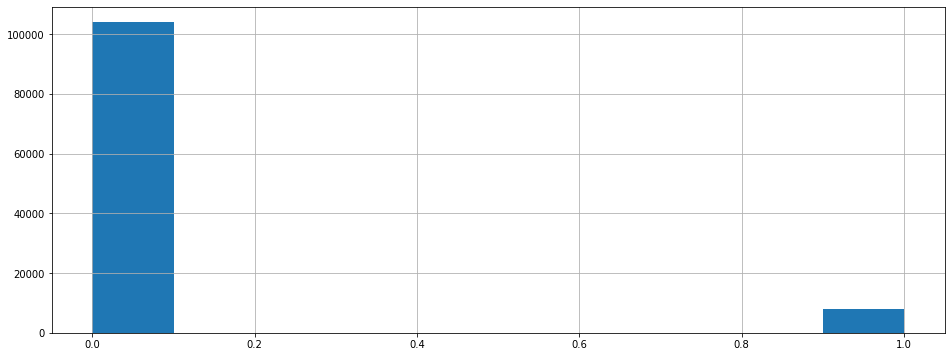



Impacto de diabetes en No-shows:
                  diabetes      %
diabetes no-show                 
0        No          82850  79.66
         Yes         21152  20.34
1        No           6631  82.11
         Yes          1445  17.89


In [115]:
cat_column_analysis (citas,'diabetes')

- Hay un 7,21% de pacientes con diabetes, y son las que menos faltan (17.89%)

### Handcap

No hay valores nulos.
Ratio de valores:
   handcap      %
0   109764  97.94
1     2109   1.88
2      189   0.17
3       13   0.01
4        3   0.00
Distribución:


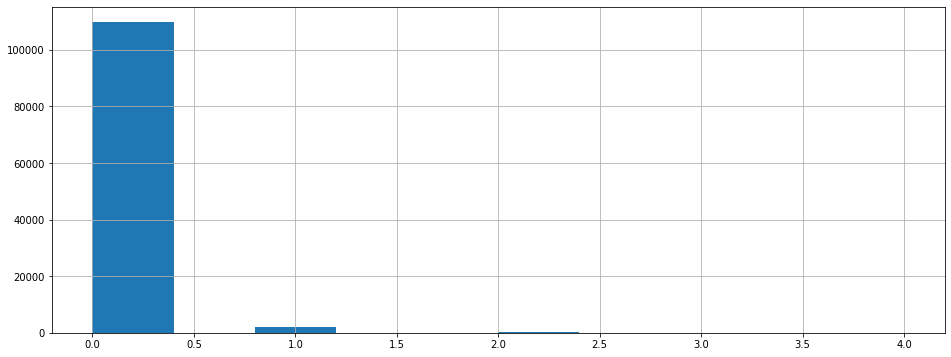



Impacto de handcap en No-shows:
                 handcap      %
handcap no-show                
0       No         87582  79.79
        Yes        22182  20.21
1       No          1737  82.36
        Yes          372  17.64
2       No           150  79.37
        Yes           39  20.63
3       No            10  76.92
        Yes            3  23.08
4       No             2  66.67
        Yes            1  33.33


In [116]:
cat_column_analysis (citas,'handcap')

De las categorias 2, 3 y 4 de Handcap no nos atreveriamos a decir nada ya que la muestra no es significativa. Por otro lado aunque la de Handcap 1 solo representa el ~2% vemos que puede ser significativo su impacto en los No-shows

In [0]:
def handcap_group(value):
    if value > 0 :
        return int(1)
    else:
        return int(0)

In [0]:
citas['handcapgroup'] = citas['handcap'].apply(handcap_group)

No hay valores nulos.
Ratio de valores:
   handcapgroup      %
0        109764  97.94
1          2314   2.06
Distribución:


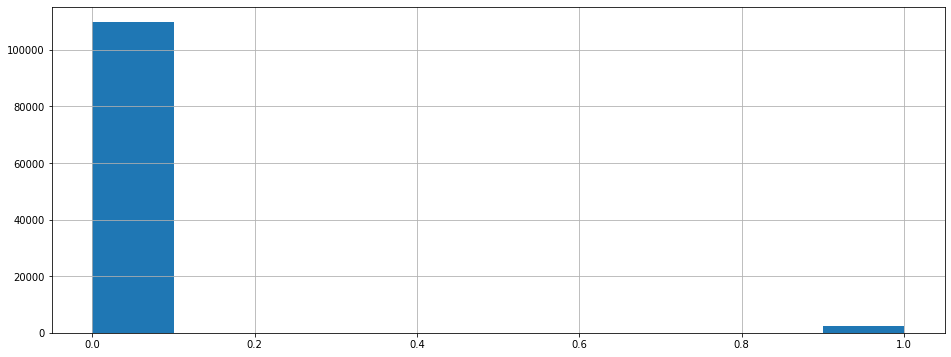



Impacto de handcapgroup en No-shows:
                      handcapgroup      %
handcapgroup no-show                     
0            No              87582  79.79
             Yes             22182  20.21
1            No               1899  82.07
             Yes               415  17.93


In [119]:
cat_column_analysis (citas,'handcapgroup')

- El 97.94% de los pacientes no son discapacitados y **faltan más (20.21%)** que los que son

### Neighbourhood

In [120]:
citas['neighbourhood'].nunique()

81

In [121]:
citas['neighbourhood'].value_counts().head(20)

JARDIM CAMBURI       7784
MARIA ORTIZ          5833
RESISTÊNCIA          4469
JARDIM DA PENHA      3922
ITARARÉ              3545
CENTRO               3369
SANTA MARTHA         3174
TABUAZEIRO           3156
JESUS DE NAZARETH    2886
BONFIM               2874
SANTO ANTÔNIO        2798
SANTO ANDRÉ          2618
CARATOÍRA            2589
JABOUR               2537
SÃO PEDRO            2489
ANDORINHAS           2339
ILHA DO PRÍNCIPE     2311
ROMÃO                2308
NOVA PALESTINA       2307
DA PENHA             2226
Name: neighbourhood, dtype: int64

In [0]:
citas['neighbourhood'] = citas['neighbourhood'].str.title()

### Variables dummies y atributos numériocs

Una vez realizado el análisis exploratorio vemos como aun tenemos algunas columnas que no son numéricas, así que decidimos convertirlas. Para ello crearemos una copia del dataset sobre el que realizaremos los cambios.

In [0]:
categorical_cols = ['gender','neighbourhood','no-show', 'samedayflag']
citas_dummies = citas.copy()

Importamos la función <code>LabelEncoder</code> de <code>sklearn.preprocessing</code> para poder realizar esta codificación.

In [124]:
# iniciamos el objeto
le = LabelEncoder()

# y lo aplicamos al listado de columnas que se definieron antes
citas_dummies[categorical_cols] = citas_dummies[categorical_cols].apply(lambda col: le.fit_transform(col))

citas_dummies.head()

,unnamed: 0,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,scheduleddate,scheduledweekday,scheduledhour,appointmentdate,appointmentweekday,appointmenthour,samedayflag,days_to_appointment,schedulehourgroup,new_age,handcapgroup
0,0,2.987250e+13,5642903,0,2016-04-29 18:38:08,2016-04-29,62,39,0,1,0,0,0,0,0,2016-04-29,4,18,2016-04-29,4,0,1,0,1,62.0,0
1,1,5.589978e+14,5642503,1,2016-04-29 16:08:27,2016-04-29,56,39,0,0,0,0,0,0,0,2016-04-29,4,16,2016-04-29,4,0,1,0,1,56.0,0
2,2,4.262962e+12,5642549,0,2016-04-29 16:19:04,2016-04-29,62,45,0,0,0,0,0,0,0,2016-04-29,4,16,2016-04-29,4,0,1,0,1,62.0,0
3,3,8.679512e+11,5642828,0,2016-04-29 17:29:31,2016-04-29,8,54,0,0,0,0,0,0,0,2016-04-29,4,17,2016-04-29,4,0,1,0,1,8.0,0
4,4,8.841186e+12,5642494,0,2016-04-29 16:07:23,2016-04-29,56,39,0,1,1,0,0,0,0,2016-04-29,4,16,2016-04-29,4,0,1,0,1,56.0,0


Procedemos a ordenar las columnas con las modificaciones realizadas.

In [0]:
citas_dummies = citas_dummies[['unnamed: 0', 'patientid', 'appointmentid', 'gender', 'scheduledday',
       'appointmentday', 'age', 'neighbourhood', 'scholarship', 'hipertension',
       'diabetes', 'alcoholism', 'handcap', 'sms_received',
       'scheduleddate', 'scheduledweekday', 'scheduledhour', 'appointmentdate',
       'appointmentweekday', 'appointmenthour', 'samedayflag',
       'schedulehourgroup', 'new_age', 'handcapgroup', 'days_to_appointment','no-show']]

In [126]:
citas_dummies.dtypes

unnamed: 0                      int64
patientid                     float64
appointmentid                   int64
gender                          int64
scheduledday           datetime64[ns]
appointmentday         datetime64[ns]
age                             int64
neighbourhood                   int64
scholarship                     int64
hipertension                    int64
diabetes                        int64
alcoholism                      int64
handcap                         int64
sms_received                    int64
scheduleddate          datetime64[ns]
scheduledweekday                int64
scheduledhour                   int64
appointmentdate        datetime64[ns]
appointmentweekday              int64
appointmenthour                 int64
samedayflag                     int64
schedulehourgroup               int64
new_age                       float64
handcapgroup                    int64
days_to_appointment             int64
no-show                         int64
dtype: objec

**texto en negrita**## Unbalanced problems

Tenemos un total de 25 columnas, de las cuales procedemos a eliminar las que no apartan información significativa como son **unnamed: 0, patientid y appointmentid**. También eliminaremos **age, y handcap**, dado que esa información la tenemos repetida en new_age y handcapgroup. 

Eliminamos también las columnas de fechas que nos generarían overfitting en el modelo: **'scheduledday', scheduleddate,'appointmentday' y 'appointmentdate'**.

In [0]:
citas_reduction = citas_dummies[['gender', 'neighbourhood', 'scholarship', 'hipertension',
       'diabetes', 'alcoholism','sms_received','scheduledweekday', 'scheduledhour',
       'appointmentweekday', 'appointmenthour', 'samedayflag',
       'schedulehourgroup', 'new_age', 'handcapgroup', 'days_to_appointment','no-show']]

Separación 80-20, 80 para entrenar el modelo y 20 para pasar luego.

In [0]:
X = citas_reduction.drop(['no-show'], axis = 1)
y = citas_reduction['no-show']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [0]:
production = pd.merge(X_test, y_test, on = X_test.index)

production.to_csv('../data/production.csv')

In [0]:
citas_dummies_reduction = pd.merge(X_train, y_train, on = X_train.index)

In [0]:
def under_sampling_nr (df, col_dep):
    
    """
    Devuelve el df reducido con NearMiss
    Input:
    *df
    *col_dep: variable dependiente
    
    """
    
    X = df.drop(col_dep, axis = 1)
    y = df[col_dep]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    
    nr = NearMiss(version = 3)
    nr = NearMiss()
    X_res, y_res = nr.fit_sample(X_train, y_train)
    
    df_temp = pd.DataFrame(X_res, columns = df.columns[:-1])
    df_temp[col_dep] = y_res
    
    return df_temp

In [0]:
citas_dummies_reduction = under_sampling_nr (citas_dummies_reduction, "no-show")

Hay un total de 33896 filas y 17 columnas.
None


,type,nan,nan_ratio_col,nan_ratio_total,unique_values,mean,std,min,25%,50%,75%,max
gender,int64,0,0.0,0.0,3,0.353228,0.483137,0.0,0.0,0.0,1.0,2.0
neighbourhood,int64,0,0.0,0.0,79,42.027024,21.793581,1.0,28.0,39.0,60.0,80.0
scholarship,int64,0,0.0,0.0,2,0.095941,0.294514,0.0,0.0,0.0,0.0,1.0
hipertension,int64,0,0.0,0.0,2,0.138010,0.344916,0.0,0.0,0.0,0.0,1.0
diabetes,int64,0,0.0,0.0,2,0.049829,0.217595,0.0,0.0,0.0,0.0,1.0
alcoholism,int64,0,0.0,0.0,4,0.031508,0.265893,0.0,0.0,0.0,0.0,3.0
sms_received,int64,0,0.0,0.0,2,0.329803,0.470148,0.0,0.0,0.0,1.0,1.0
scheduledweekday,int64,0,0.0,0.0,6,1.812928,1.320627,0.0,1.0,2.0,3.0,5.0
scheduledhour,int64,0,0.0,0.0,16,10.574257,3.143080,6.0,8.0,10.0,13.0,21.0
appointmentweekday,int64,0,0.0,0.0,6,1.823608,1.311431,0.0,1.0,2.0,3.0,5.0


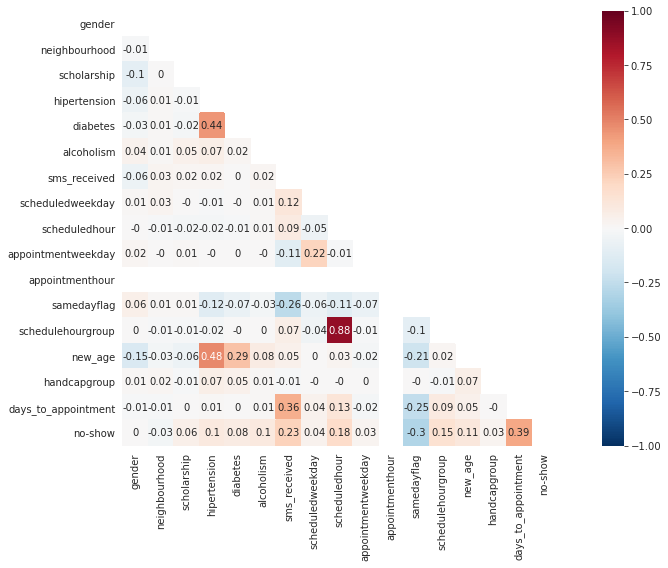

In [0]:
describe_df (citas_dummies_reduction)

In [0]:
citas_dummies_reduction['no-show']

0        0
1        0
2        0
3        0
4        0
        ..
33891    1
33892    1
33893    1
33894    1
33895    1
Name: no-show, Length: 33896, dtype: int64

## Reducción de la dimensionalidad

In [0]:
print(f'En el data set citas_dummies_reduction hay un total de {citas_dummies_reduction.shape[0]} filas y {citas_dummies_reduction.shape[1]} columnas.')

En el data set citas_dummies_reduction hay un total de 33896 filas y 17 columnas.


### Heatmap y correlaciones

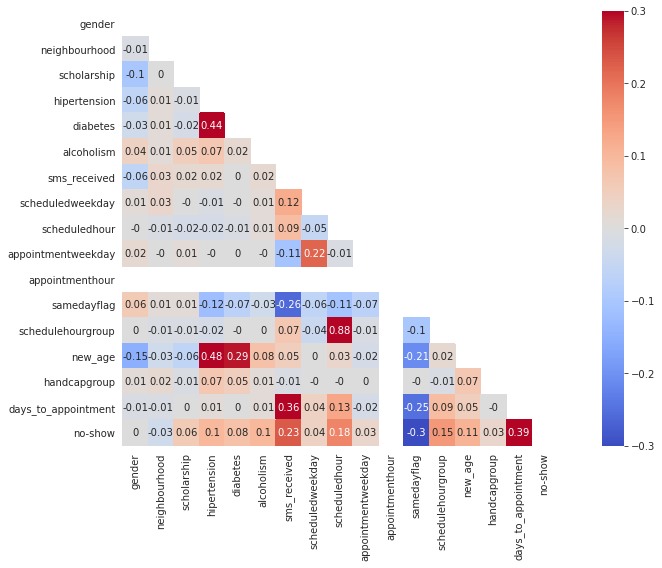

In [0]:
corr = citas_dummies_reduction.corr().round(2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 8))

    ax = sns.heatmap(corr, cmap = 'coolwarm', annot=True,  mask=mask, vmax=.3, square=True)

### Eliminación hacia atrás. Opciones 1 y 2

La <b>eliminación hacia atrás </b> se suele llevar a cabo en 5 pasos:
   1. Seleccionar el nivel de significación.
   2. Calcular el modelo con todas las posibles variables predictoras
   3. Se considerará variable predictora toda aquella que tenga el p.valor más alto y este, a su vez, sea mayor que nuestro nivel de significación. Si esto sucede, procemos con el siguiente paso.  Si el p.valor más alto está por debajo del nivel de significación el modelo estará listo.
   4. Se elimina la variable predictora.
   5. Ajustamos el modelo desde el principio sin dicha variable y volvemos al 3er punto.

Separamos del dataset la variable dependiente a predecir.

In [0]:
X = citas_dummies_reduction.iloc[:, :-1].values
y = citas_dummies_reduction.iloc[:, -1].values

In [0]:
X, y = citas_dummies_reduction.drop('no-show', axis =1).values, citas_dummies_reduction['no-show'].values

#### Opción 1.

In [0]:
# Construir el modelo óptimo de RLM utilizando la Eliminación hacia atrás
X = np.append(arr = np.ones((X.shape[0],1)).astype(int), values = X, axis = 1)

In [0]:
list(range(0,X.shape[1]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [0]:
X_opt = X[:,[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16]]
regression_OLS = sm.OLS(y, X_opt).fit()
regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     736.0
Date:                Thu, 07 May 2020   Prob (F-statistic):               0.00
Time:                        21:06:24   Log-Likelihood:                -20101.
No. Observations:               33896   AIC:                         4.023e+04
Df Residuals:                   33881   BIC:                         4.036e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1662      0.016     10.104      0.000       0.134       0.198
x1             0.0342      0.005      6.787      0.000       0.024       0.044
x2            -0.0007      0.000     -6.657      0.000      -0.001      -0.001
x3             0.1163      0.008     14.246      0.000       0.100       0.132
x4             0.0631      0.008      7.466      0.000       0.047       0.080
x5             0.0925      0.012      7.568      0.000       0.069       0.116
x6             0.1441      0.009     15.987      0.000       0.126       0.162
x7             0.0723      0.006     12.943      0.000       0.061       0.083
x8             0.0235      0.002     14.482      0.000       0.020       0.027
x9             0.0124      0.002      6.767      0.000       0.009       0.016
x10           -0.1886      0.005    -36.010      0.000      -0.199      -0.178
x11           -0.0324      0.011     -3.041      0.002      -0.053      -0.012
x12            0.0003      0.000      2.598      0.009    8.33e-05       0.001
x13            0.1246      0.020      6.333      0.000       0.086       0.163
x14            0.0103      0.000     56.684      0.000       0.010       0.011
==============================================================================
Omnibus:                    20971.120   Durbin-Watson:                   0.460
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1893.161
Skew:                          -0.002   Prob(JB):                         0.00
Kurtosis:                       1.842   Cond. No.                         487.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
import statsmodels.api as sm
def backwardElimination(x, sl):    
    numVars = len(x[0])    
    for i in range(0, numVars):        
        regressor_OLS = sm.OLS(y, x.tolist()).fit()        
        maxVar = max(regressor_OLS.pvalues).astype(float)        
        if maxVar > sl:            
            for j in range(0, numVars - i):                
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):                    
                    x = np.delete(x, j, 1)    
    regressor_OLS.summary()    
    return x 
 
SL = 0.05
X_opt = X[:,list(range(0,X.shape[1]))]
citas_modeled = backwardElimination(X_opt, SL)

In [0]:
pd.DataFrame(citas_modeled).head() 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,1.0,50.0,1.0,0.0,0.0,0.0,0.0,7.0,2.0,1.0,0.0,11.0,0.0,0.0
1,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,7.0,3.0,1.0,0.0,3.0,0.0,0.0
2,1.0,1.0,50.0,1.0,0.0,0.0,0.0,0.0,7.0,2.0,1.0,0.0,10.0,0.0,0.0
3,1.0,1.0,50.0,1.0,0.0,0.0,0.0,0.0,7.0,2.0,1.0,0.0,10.0,0.0,0.0
4,1.0,1.0,29.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,1.0,0.0,16.0,0.0,0.0


In [0]:
citas_dummies_reduction.head()

,gender,neighbourhood,scholarship,hipertension,diabetes,alcoholism,sms_received,scheduledweekday,scheduledhour,appointmentweekday,appointmenthour,samedayflag,schedulehourgroup,new_age,handcapgroup,days_to_appointment,no-show
0,1,50,1,0,0,0,0,2,7,2,0,1,0,11.0,0,0,0
1,1,6,0,0,0,0,0,3,7,3,0,1,0,3.0,0,0,0
2,1,50,1,0,0,0,0,2,7,2,0,1,0,10.0,0,0,0
3,1,50,1,0,0,0,0,2,7,2,0,1,0,10.0,0,0,0
4,1,29,0,0,0,0,0,4,8,4,0,1,0,16.0,0,0,0


In [0]:
columns = ['none','gender', 'neighbourhood', 'scholarship', 'hipertension', 'diabetes',
       'alcoholism', 'sms_received', 'scheduledhour',
       'appointmentweekday', 'samedayflag',
       'schedulehourgroup', 'new_age', 'handcapgroup', 'days_to_appointment']

In [0]:
opt1 = (pd.DataFrame(citas_modeled, columns = columns).iloc[:,1:]).join(citas_dummies_reduction['no-show'], on = citas_dummies_reduction.index)

In [0]:
opt1.head()

,gender,neighbourhood,scholarship,hipertension,diabetes,alcoholism,sms_received,scheduledhour,appointmentweekday,samedayflag,schedulehourgroup,new_age,handcapgroup,days_to_appointment,no-show
0,1.0,50.0,1.0,0.0,0.0,0.0,0.0,7.0,2.0,1.0,0.0,11.0,0.0,0.0,0
1,1.0,6.0,0.0,0.0,0.0,0.0,0.0,7.0,3.0,1.0,0.0,3.0,0.0,0.0,0
2,1.0,50.0,1.0,0.0,0.0,0.0,0.0,7.0,2.0,1.0,0.0,10.0,0.0,0.0,0
3,1.0,50.0,1.0,0.0,0.0,0.0,0.0,7.0,2.0,1.0,0.0,10.0,0.0,0.0,0
4,1.0,29.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,1.0,0.0,16.0,0.0,0.0,0


In [0]:
opt1.to_csv('data/opt1.csv',index = False)

#### Opción 2

In [0]:
opt2 = citas_dummies_reduction.copy()

In [0]:
def drop_corr (df, col):
    df.drop(col, inplace=True, axis=1)
    heatmap_ml(df)

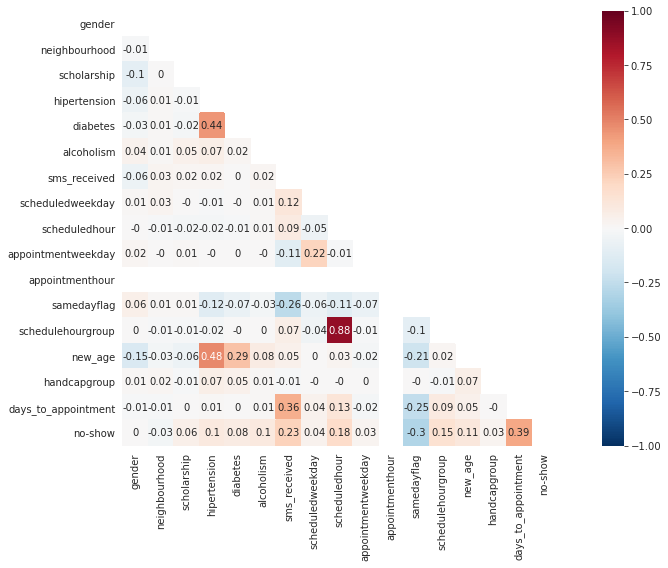

In [0]:
heatmap_ml(opt2)

Se aprecia solo una alta correlación entre <code>scheduledhour</code> y <code>scheduledhourgroup</code>, que de hecho es una de las columnas que se decidió agrupar. Procedemos a eliminar <code>scheduledhour</code> por ser la más específica.

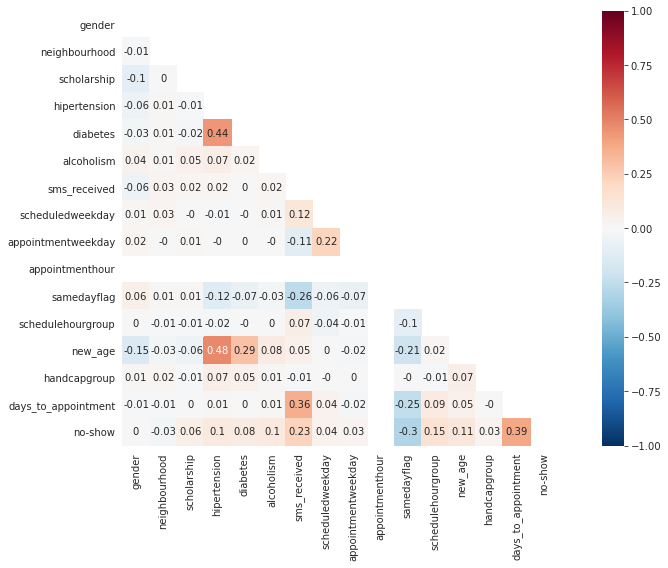

In [0]:
drop_corr(opt2, 'scheduledhour')

In [0]:
opt2.to_csv('data/opt2.csv',index = False)

### Recursive Feature Elimination. Opción 3

In [0]:
opt3 = citas_dummies_reduction.copy()

En este caso, el parámetro <code>n_features_to_select=10</code> es el que decide el número de variables que quieres quedarte. 1 son las más importantes, los números más altos las que menos...

In [0]:
def RFEselection (df, y, col, random_state):
    """
    df = dataset
    y = variable a predecir
    col = número de columnas que quieres quedarte
    random_state
    
    otuput = df nuevo
    
    """
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(y, axis =1), df[y], stratify = df[y], shuffle = True, random_state=random_state)
    selector = RFE(LinearRegression(), n_features_to_select=col)
    selector = selector.fit(X_train, y_train)
    rank = pd.DataFrame(selector.ranking_, index = X_train.columns, columns = ["rank"])
    
    return df[rank[rank["rank"]==1].index]

In [0]:
opt3 = (RFEselection (opt3, "no-show", 10, 42)).join(citas_dummies_reduction['no-show'], on = citas_dummies_reduction.index)

In [0]:
opt3.head()

,gender,scholarship,hipertension,diabetes,alcoholism,sms_received,scheduledhour,samedayflag,schedulehourgroup,handcapgroup,no-show
0,1,1,0,0,0,0,7,1,0,0,0
1,1,0,0,0,0,0,7,1,0,0,0
2,1,1,0,0,0,0,7,1,0,0,0
3,1,1,0,0,0,0,7,1,0,0,0
4,1,0,0,0,0,0,8,1,0,0,0


In [0]:
opt3.to_csv('data/opt3.csv',index = False)

### Random Forest Classifier. Feature importance. Opción 4

In [0]:
opt4 = citas_dummies_reduction.copy()

In [0]:
X = opt4.iloc[:,:-1].values
y = opt4.iloc[:, -1].values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, shuffle = True, random_state = 42)

In [0]:
tree = RandomForestClassifier().fit(X_train, y_train)

In [0]:
def plot_feature_importances_show(df, model):
    
    names = df.columns[model.feature_importances_.argsort()]
    model.feature_importances_.sort()
    plt.figure(figsize=(8,6))
    n_features = len(names)
    plt.barh(range(n_features), np.sort(tree.feature_importances_), align='center')
    plt.yticks(np.arange(n_features), names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

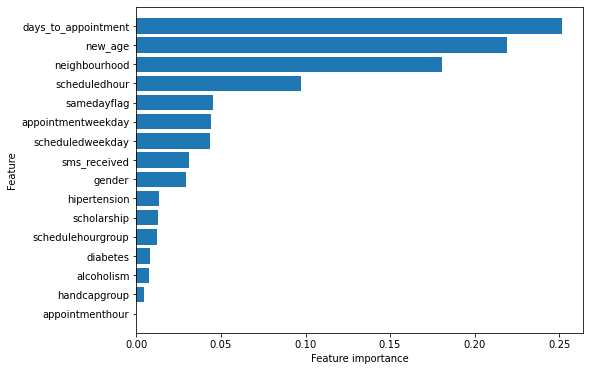

In [0]:
plot_feature_importances_show(opt4, tree)

In [0]:
opt4 = opt4[['gender', 'neighbourhood', 'scholarship', 'hipertension', 'diabetes',
       'alcoholism', 'sms_received', 'scheduledweekday', 'scheduledhour',
       'appointmentweekday', 'samedayflag',
       'schedulehourgroup', 'new_age', 'handcapgroup', 'days_to_appointment',
       'no-show']]

In [0]:
opt4.to_csv("data/opt4.csv", index = False)

### PCA (Principal Component Analysis)

In [0]:
pca_df = citas_dummies_reduction.copy()

In [0]:
X = pca_df.iloc[:,:-1].values
y = pca_df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, shuffle = True, random_state = 42)

In [0]:
sc_X = StandardScaler()
X_train_pca = sc_X.fit_transform(X_train)
X_test_pca = sc_X.transform(X_test)

In [0]:
pca = PCA(n_components = 2)
pc = pca.fit_transform(X_train_pca)

In [0]:
pca_df = pd.DataFrame(data=pc, columns = ['PC1', 'PC2'])

In [0]:
pca_df['no-show'] = y_train

Añadimos el resto de columnas para poder hacer el <code>hue</code>

In [0]:
e = 0
for col in citas_dummies_reduction.columns[:-1]:
    pca_df[col] = X_train[:,e]
    e+=1

Creamos un desplegable para elegir con que pintar

In [0]:
def hue_plot(hue): 
    sns.relplot(x='PC1', y='PC2', hue=hue, data=pca_df)  
    
_= interact(hue_plot, hue= pca_df.columns[2:])

interactive(children=(Dropdown(description='hue', options=('no-show', 'gender', 'neighbourhood', 'scholarship'…

## Modeling

### Logistic Regression

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [0]:
logreg = LogisticRegression().fit(X_train, y_train)
print("Training set accuracy: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

Training set accuracy: 0.719
Test set accuracy: 0.717


/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
y_pred = logreg.fit(X_train, y_train).predict(X_test)

/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Model Evaluation

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

In [0]:
confusion_matrix(y_test, y_pred)

array([[3122, 1115],
       [1281, 2956]])

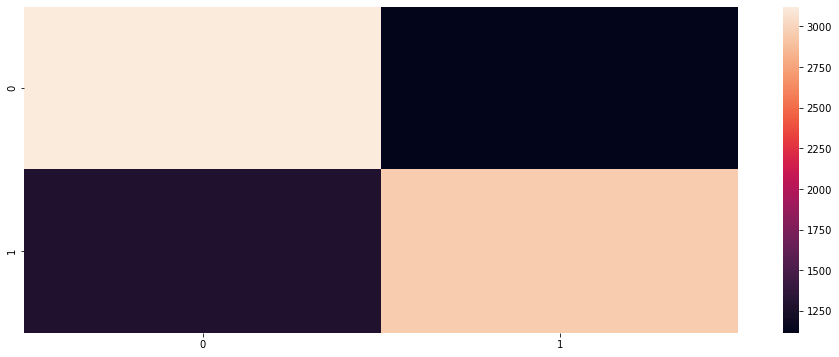

In [0]:
sns.heatmap(confusion_matrix(y_test, y_pred))

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.74      0.72      4237
           1       0.73      0.70      0.71      4237

    accuracy                           0.72      8474
   macro avg       0.72      0.72      0.72      8474
weighted avg       0.72      0.72      0.72      8474



### Random forest

In [49]:
citas.columns

Index(['neighbourhood', 'scholarship', 'diabetes', 'alcoholism',
       'sms_received', 'scheduledhour', 'appointmenthour', 'samedayflag',
       'schedulehourgroup', 'new_age', 'days_to_appointment'],
      dtype='object')

In [48]:
X = citas.iloc[:, :-1]
y = citas['no-show']

KeyError: ignored

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, shuffle = True, random_state = 42)

In [0]:
tree = RandomForestClassifier().fit(X_train, y_train)

In [0]:
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.744


#### Baseline report

In [0]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='roc_auc'))
    y_pred = model.predict(X_test)
    #logloss      = log_loss(y_test, y_pred)   # SVC & LinearSVC unable to use cvs

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc]})
                             #'logloss'      : [logloss]})   # timetaken: to be used for comparison later
    return df_model

In [0]:
# to evaluate baseline models
models = {  #'gnb': GaussianNB(),
#             'bnb': BernoulliNB(),
#             'mnb': MultinomialNB(),
             'logit': LogisticRegression(solver = "sag"),
             'knn': KNeighborsClassifier(),
             'decisiontree': DecisionTreeClassifier(),
             'randomforest': RandomForestClassifier(),
             #'svc': SVC(probability=True),
#             'linearsvc': LinearSVC()
         }

In [0]:
models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])

/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag

In [0]:
models_df

### ROC/AUC

#### La curva ROC y AUC son importantes métricas de evaluación para calcular la performance de cualquier modelo de clasificación

- ROC es una curva de probabilidad y AUC representa el grado o medida de separabilidad. Dice cuánto es capaz el modelo de distinguir entre clases
- Dependiendo de qué **área bajo la curva es más grande**, podemos concluir que clasificador hizo un mejor trabajo en la clasificación de la No-show rate

In [0]:
y_pred =  logreg.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, lw=3, label='logreg (area = %0.3f)' % auc(fpr, tpr))

In [0]:
auc(fpr, tpr)

### Cross validation and hyperparameter tuning

In [0]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='roc_auc'))
    y_pred = model.predict(X_test)
    logloss      = log_loss(y_test, y_pred)   # SVC & LinearSVC unable to use cvs

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss]})   # timetaken: to be used for comparison later
    return df_model

In [0]:
# evaluating the Logistic Regression cross validation scores
baseline_report(logreg, X_train, X_test, y_train, y_test, 'LogisticRegression')

### Classification models comparison

In [0]:
# evaluating LogisticRegression, RandomForest and SVC models 

models = {  'logit': LogisticRegression(),
            'randomforest': RandomForestClassifier(),
            'svc': SVC(probability=True)}

In [0]:
 models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) 
                       for (name, model) in models.items()])

In [0]:
models_df.reset_index(inplace=True, drop=True)

In [0]:
models_df

### AUC

In [0]:
# plot the ROC curves
plt.figure(figsize=(10,10))


for (name, model) in models.items():
    y_pred = model.fit(X_train, y_train).predict_proba(X_test)[:,1]
        
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, lw=3, label=name + ' (area = %0.3f)' % auc(fpr, tpr))
    
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

### MLP 

- Neural Nets for Multiclass Classification
- This is a computationally preferable way to get more complexity in our decision boundaries as compared to just adding more features to our simple logistic regression

The advantages of Multi-layer Perceptron are:

- Capability to learn non-linear models.
- Capability to learn models in real-time (on-line learning) using partial_fit.

The disadvantages of Multi-layer Perceptron (MLP) include:

- MLP with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore different random weight initializations can lead to different validation accuracy.
- MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.
- MLP is sensitive to feature scaling.

The class **MLPClassifier** is the tool to use when you want a neural net to do classification for you - to train it you use the same old X and y inputs that we fed into our LogisticRegression object.

In [0]:
clf = MLPClassifier(solver='sgd', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=42)

#clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X, y)

MLPClassifier has an attribute that actually stores the progression of the loss function during the fit. It's called **loss_curve_** and for some baffling reason it isn't mentioned in the documentation.

In [0]:
fig, ax = plt.pyplot.subplots()
ax.plot(clf.loss_curve_)

In [0]:
clf.learning_rate_init = 1
clf.fit(X_train, y_train)

In [0]:
fig, ax = plt.pyplot.subplots()
ax.plot(clf.loss_curve_)